In [ ]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import xticks
from nltk.corpus import stopwords
import nltk
import re
from nltk.stem import WordNetLemmatizer
import string
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import defaultdict
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import tensorflow as tf
from sklearn.metrics import f1_score
from wordcloud import WordCloud,STOPWORDS
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from keras.preprocessing.sequence import pad_sequences
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding,Activation,Dropout
from keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D,LSTM

In [ ]:
# load train and test datasets
train= pd.read_csv('/content/drive/MyDrive/dataset /twitter disaster /train.csv')
test=pd.read_csv('/content/drive/MyDrive/dataset /twitter disaster /test.csv')

In [ ]:
train.shape, test.shape

((7613, 5), (3263, 4))

In [ ]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train.isnull().sum().sort_values(ascending = False)

location    2533
keyword       61
id             0
text           0
target         0
dtype: int64

In [ ]:
# function to draw bar plot
def draw_bar_plot(category,length,xlabel,ylabel,title,sub):
    plt.subplot(2,2,sub)
    plt.bar(category, length,color = 'grbkymc')
    plt.legend()
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.title(title, fontsize=15)
    #plt.show()

In [ ]:
# function to draw histogram
def draw_hist(xlabel, ylabel,title,target,sub,color):
    plt.subplot(1,2,sub)
    plt.hist(train[train.target==target]["length"],color = color)
    plt.title(title,fontsize=25)
    plt.xlabel(xlabel,fontsize=15)
    plt.ylabel(ylabel,fontsize=15)
    plt.ylim(0,1200)
    plt.grid()

In [ ]:
# function to draw graphs for stopwords and punctuations
def draw_bar_n_plot(data,title):
# lets visualize the top 10 stop words
    x,y=zip(*data)

    plt.figure(figsize = (25,10))
    plt.subplot(1,2,1)
    plt.bar(x,y,color='grbkymc')
    plt.title("Top 10 "+ title,fontsize=25)
    plt.xlabel(title,fontsize=15)
    plt.ylabel("Count",fontsize=15)
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(x,y,'g')
    plt.title("Top 10 "+ title,fontsize=25)
    plt.xlabel(title,fontsize=15)
    plt.ylabel("Count",fontsize=15)
    plt.grid()
# check class distri

In [ ]:
# check class distribution

print("No. of Real Disaster Tweets (Target = 1):",len(train[train["target"]==1]))
print("No. of Fake Disaster Tweets (Target = 0):",len(train[train["target"]==0]))

No. of Real Disaster Tweets (Target = 1): 3271
No. of Fake Disaster Tweets (Target = 0): 4342


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  after removing the cwd from sys.path.


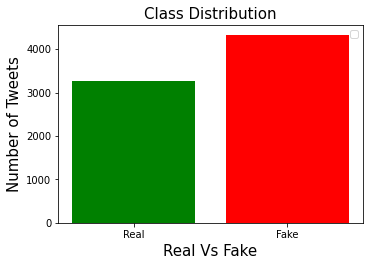

In [ ]:
# lets visualize the class distribution
plt.figure(figsize = (12,8))
draw_bar_plot(["Real","Fake"],[len(train[train.target==1]), len(train[train.target==0])],"Real Vs Fake","Number of Tweets","Class Distribution",1)

In [11]:
# we will now check the length of "real disaster" vs lenght of "fake disaster" tweets
# lets first add a new field to the dataset called "length"
def length(text):    
    return len(text)

train["length"]= train.text.apply(length)

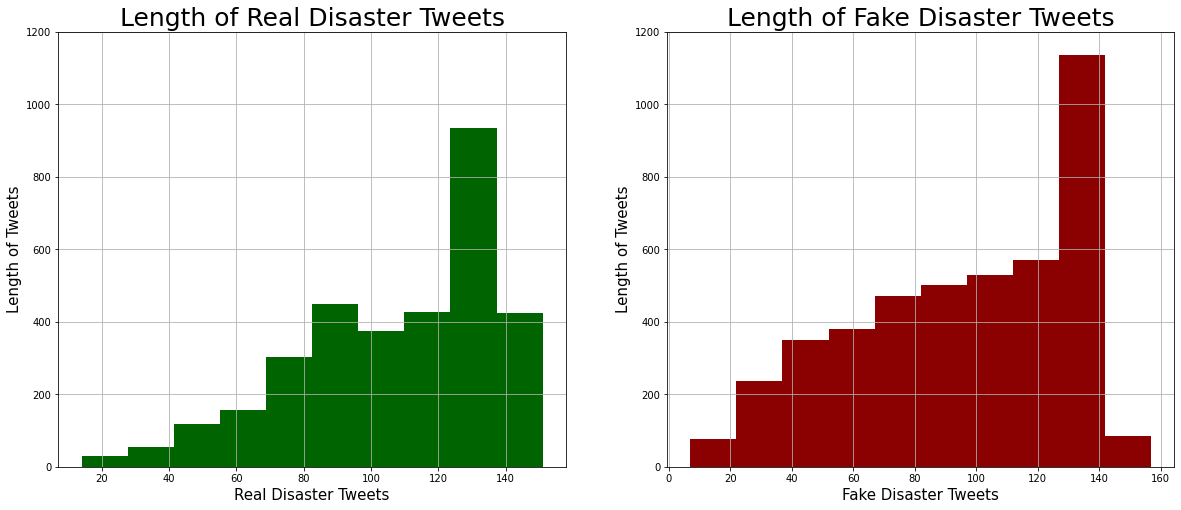

In [12]:
# lets see the distribution of length of tweets real vs fake

plt.figure(figsize = (20,8))
draw_hist("Real Disaster Tweets","Length of Tweets","Length of Real Disaster Tweets",1, 1,"darkgreen")
draw_hist("Fake Disaster Tweets","Length of Tweets","Length of Fake Disaster Tweets",0, 2,"darkred")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  after removing the cwd from sys.path.


target
1    108.113421
0     95.706817
Name: length, dtype: float64


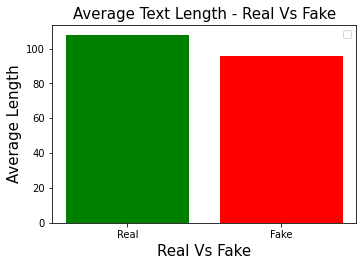

In [13]:
# lets check the average lenght of real vs fake tweets
print(train.groupby("target").mean()["length"].sort_values(ascending = False))

# lets visualize the class distribution
plt.figure(figsize = (12,8))
draw_bar_plot(["Real","Fake"],[train[train.target==1].mean()["length"], train[train.target==0].mean()["length"]],"Real Vs Fake","Average Length","Average Text Length - Real Vs Fake",1)

In [14]:
# lets drop the column
train.drop("length",1,inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
#lets save stopwords in a variable

stop = list(stopwords.words("english"))

In [19]:
# stopwords present in the whole dataset
sw = []
for message in train.text:
    for word in message.split():
        if word in stop:
            sw.append(word)


# lets convert the list to a dictinoary which would contain the stop words and their frequency
wordlist = nltk.FreqDist(sw)
# lets save the 10 most frequent stopwords
top10 = wordlist.most_common(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  


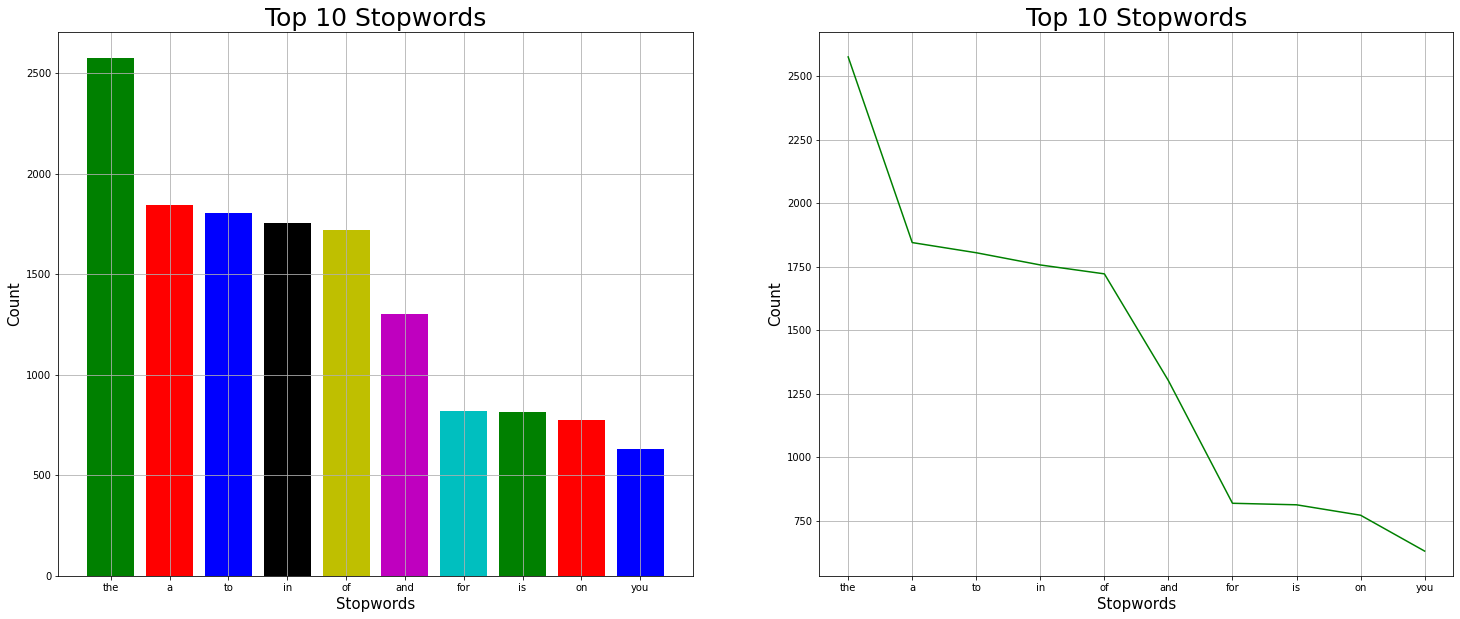

In [20]:
# Graphs for top 10 stopwords present in all the tweets
draw_bar_n_plot(top10,"Stopwords")

In [21]:
# save list of punctuation/special characters in a variable
punctuation = list(string.punctuation)

In [22]:
# punctuations present in all the tweets 
pun = []
for message in train.text:
    for word in message.split():
        if word in punctuation:
            pun.append(word)


# lets convert the list to a dictinoary which would contain the punctuations and their frequency
wordlist = nltk.FreqDist(pun)
# lets save the 10 most frequent stopwords
top10 = wordlist.most_common(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  


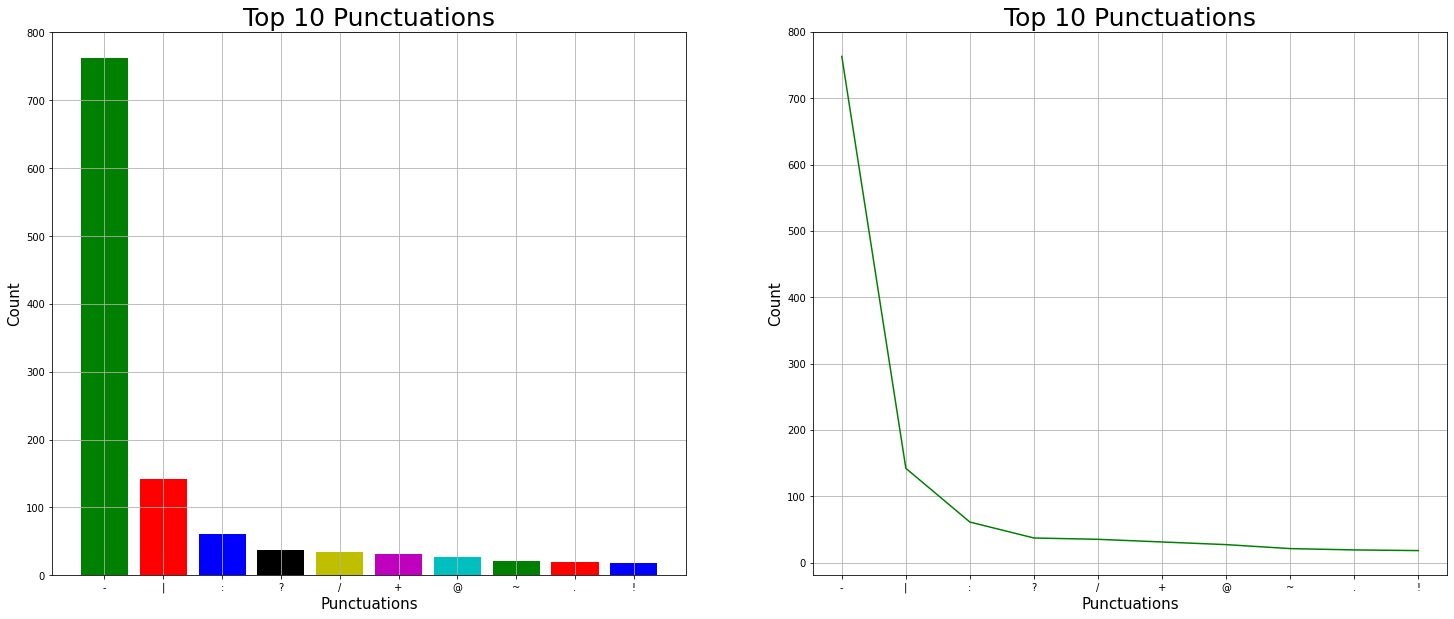

In [23]:
# draw graphs for top10 Punctuations
draw_bar_n_plot(top10,"Punctuations") 

In [24]:
# Let's check stop words and punctuations in "Real Disaster Tweets"
stop_real = []
pun_real  = []
for message in train[train.target==1]["text"]:
    for word in message.split():
        if word in stop:
            stop_real.append(word)
        if word in punctuation:
            pun_real.append(word)


# lets convert the list to a dictinoary which would contain the stop word and its frequency
stop_real_wordlist = nltk.FreqDist(stop_real)
pun_real_wordlist =  nltk.FreqDist(pun_real)

# lets save the 10 most frequent stopwords
stop_real_top10 = stop_real_wordlist.most_common(10)
pun_real_top10  = pun_real_wordlist.most_common(10)

In [25]:
# Let's check "Fake Disaster Tweets" and create a list of stop words and punctuations
stop_fake = []
pun_fake  = []
for message in train[train.target==0]["text"]:
    for word in message.split():
        if word in stop:
            stop_fake.append(word)
        if word in punctuation:
            pun_fake.append(word)


# lets convert the list to a dictinoary which would contain the stop word and its frequency
stop_fake_wordlist = nltk.FreqDist(stop_fake)
pun_fake_wordlist =  nltk.FreqDist(pun_fake)

# lets save the 10 most frequent stopwords
stop_fake_top10 = stop_fake_wordlist.most_common(10)
pun_fake_top10  = pun_fake_wordlist.most_common(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  after removing the cwd from sys.path.


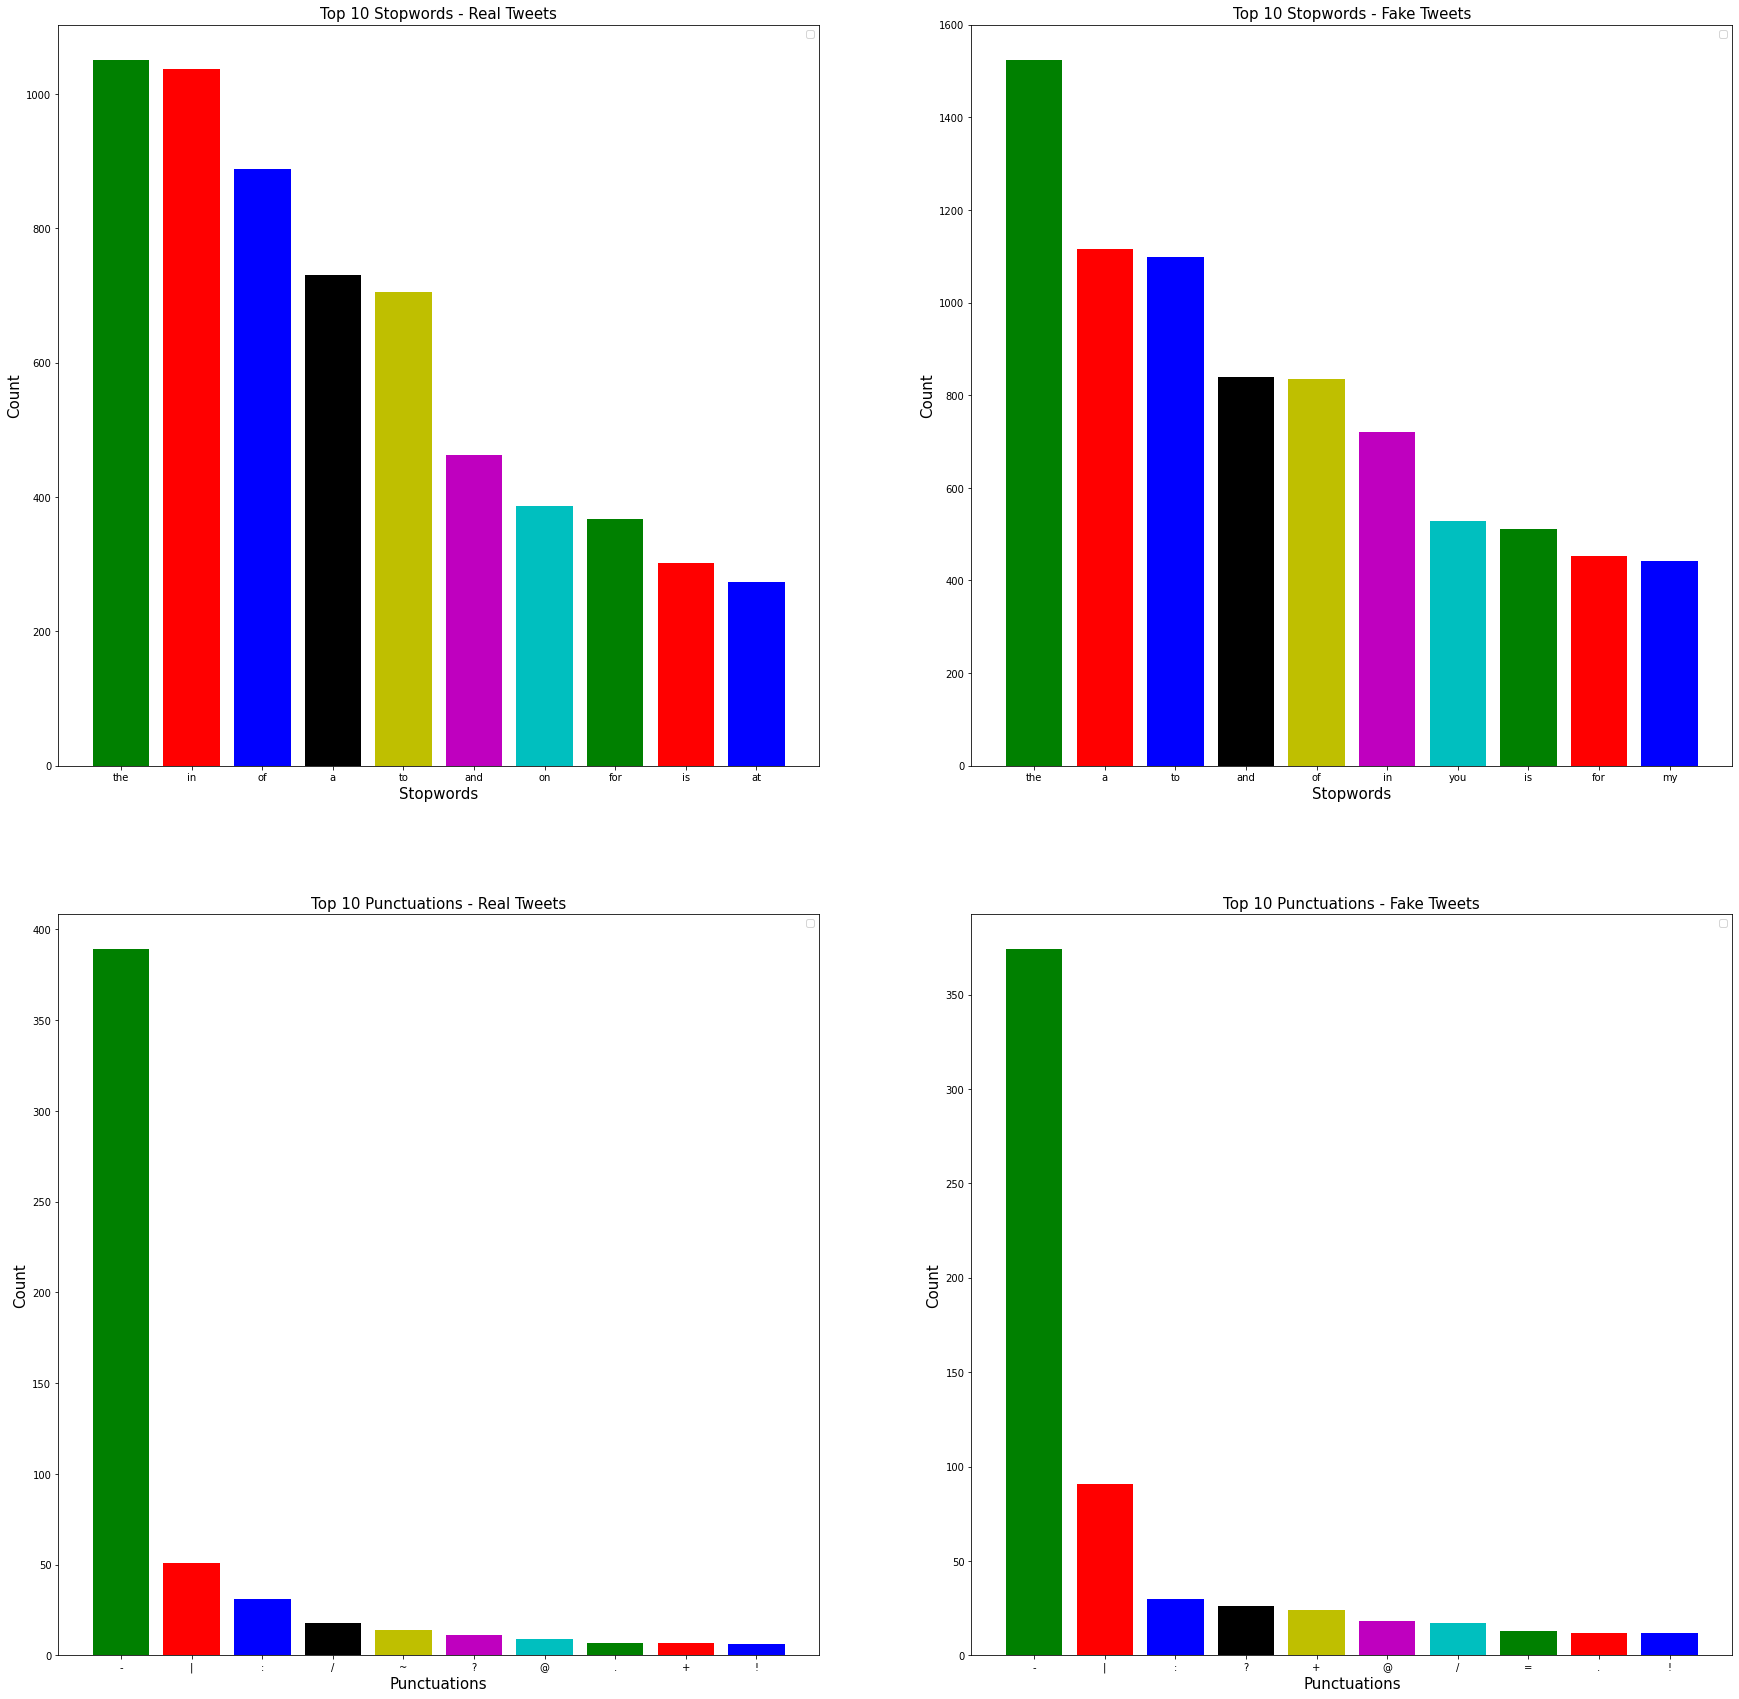

In [26]:
x_stop_real,y_stop_real=zip(*stop_real_top10)
x_pun_real, y_pun_real =zip(*pun_real_top10)

x_stop_fake,y_stop_fake=zip(*stop_fake_top10)
x_pun_fake, y_pun_fake=zip(*pun_fake_top10)


plt.figure(figsize = (30,30))
draw_bar_plot(x_stop_real,y_stop_real,"Stopwords","Count","Top 10 Stopwords - Real Tweets",1)
draw_bar_plot(x_stop_fake,y_stop_fake,"Stopwords","Count","Top 10 Stopwords - Fake Tweets",2)
draw_bar_plot(x_pun_real,y_pun_real,"Punctuations","Count","Top 10 Punctuations - Real Tweets",3)
draw_bar_plot(x_pun_fake,y_pun_fake,"Punctuations","Count","Top 10 Punctuations - Fake Tweets",4)

In [27]:
# create an object to convert the words to its lemma form
lemma = WordNetLemmatizer()

In [28]:
# lets make a combine list of stopwords and punctuations
sw_pun = stop + punctuation

In [29]:
# function to preprocess the messages
def preprocess(tweet):
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet) # removing urls 
    tweet = re.sub('[^\w]',' ',tweet) # remove embedded special characters in words (for example #earthquake)         
    tweet = re.sub('[\d]','',tweet) # this will remove numeric characters
    tweet = tweet.lower()
    words = tweet.split()  
    sentence = ""
    for word in words:     
        if word not in (sw_pun):  # removing stopwords & punctuations                
            word = lemma.lemmatize(word,pos = 'v')  # converting to lemma    
            if len(word) > 3: # we will consider words with length  greater than 3 only
                sentence = sentence + word + ' '             
    return(sentence)

In [30]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [31]:
# apply preprocessing functions on the train and test datasets
train['text'] = train['text'].apply(lambda s : preprocess(s))
test ['text'] = test ['text'].apply(lambda s : preprocess(s))

In [32]:
# function to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [33]:
# applying the function on the train and the test datasets
train['text'] = train['text'].apply(lambda s : remove_emoji(s))
test ['text'] = test ['text'].apply(lambda s : remove_emoji(s))

In [34]:
# function to create vocab
from collections import Counter
def create_vocab(df):
    vocab = Counter()
    for i in range(df.shape[0]):
        vocab.update(df.text[i].split())
    return(vocab)

In [35]:
# concatenate training and testing datasets
master=pd.concat((train,test)).reset_index(drop=True)

# call vocabulary creation function on master dataset
vocab = create_vocab(master)

# lets check the no. of words in the vocabulary
len(vocab)

16442

In [36]:
# lets check the most common 50 words in the vocabulary
vocab.most_common(50)

[('like', 560),
 ('fire', 534),
 ('bomb', 338),
 ('news', 299),
 ('people', 286),
 ('burn', 262),
 ('time', 254),
 ('kill', 253),
 ('make', 248),
 ('attack', 240),
 ('flood', 233),
 ('crash', 232),
 ('build', 231),
 ('emergency', 229),
 ('video', 228),
 ('come', 223),
 ('disaster', 220),
 ('take', 217),
 ('would', 214),
 ('body', 209),
 ('think', 204),
 ('police', 199),
 ('look', 193),
 ('know', 192),
 ('love', 190),
 ('watch', 188),
 ('home', 187),
 ('storm', 187),
 ('still', 181),
 ('train', 177),
 ('suicide', 177),
 ('live', 172),
 ('first', 170),
 ('collapse', 169),
 ('back', 164),
 ('scream', 164),
 ('california', 159),
 ('want', 156),
 ('drown', 152),
 ('cause', 151),
 ('need', 150),
 ('work', 149),
 ('today', 149),
 ('world', 148),
 ('nuclear', 148),
 ('hiroshima', 147),
 ('year', 143),
 ('full', 143),
 ('service', 142),
 ('destroy', 138)]

In [37]:
# create the final vocab by considering words with more than one occurence
final_vocab = []
min_occur = 2
for k,v in vocab.items():
    if v >= min_occur:
        final_vocab.append(k)

In [38]:
# lets check the no. of the words in the final vocabulary
len(final_vocab)

6025

In [39]:
# function to filter the dataset, keep only words which are present in the vocab
def filter(tweet):
    sentence = ""
    for word in tweet.split():  
        if word in final_vocab:
            sentence = sentence + word + ' '
    return(sentence)

In [40]:
# apply filter function on the train and test datasets
train['text'] = train['text'].apply(lambda s : filter(s))
test ['text'] = test ['text'].apply(lambda s : filter(s))

In [41]:
# lets take a look at the update training dataset
train.text.head()

0               deeds reason earthquake allah forgive 
1                             forest fire near canada 
2    residents shelter place officer evacuation she...
3    people receive wildfires evacuation order cali...
4    send photo ruby alaska smoke wildfires pour sc...
Name: text, dtype: object

In [42]:
# lets create seperate datasets from real and fake tweets
real = train[train.target==1].reset_index()
fake = train[train.target==0].reset_index()

In [43]:
# function to create top 100 n-grams
def get_ngrams(data,n):
    all_words = []
    for i in range(len(data)):
        temp = data["text"][i].split()
        for word in temp:
            all_words.append(word)

    tokenized = all_words
    esBigrams = ngrams(tokenized, n)

    esBigram_wordlist = nltk.FreqDist(esBigrams)
    top100 = esBigram_wordlist.most_common(100)
    top100 = dict(top100)
    df_ngrams = pd.DataFrame(sorted(top100.items(), key=lambda x: x[1])[::-1])
    return df_ngrams

In [44]:
# function to visualize the top 100 n-grams in real and fake disaster tweets
def draw_barplots(real,fake,title):
    plt.figure(figsize = (40,80),dpi=100)

    plt.subplot(1,2,1)
    sns.barplot(y=real[0].values[:100], x=real[1].values[:100], color='green')
    plt.title("Top 100" + title + "in Real Tweets",fontsize=15)
    
    plt.subplot(1,2,2)
    sns.barplot(y=fake[0].values[:100], x=fake[1].values[:100],color='red')
    plt.title("Top 100" + title + "in Fake Tweets",fontsize=15)

In [45]:
# lets create top 100 unigrams
real_unigrams = get_ngrams(real,1)
fake_unigrams = get_ngrams(fake,1)

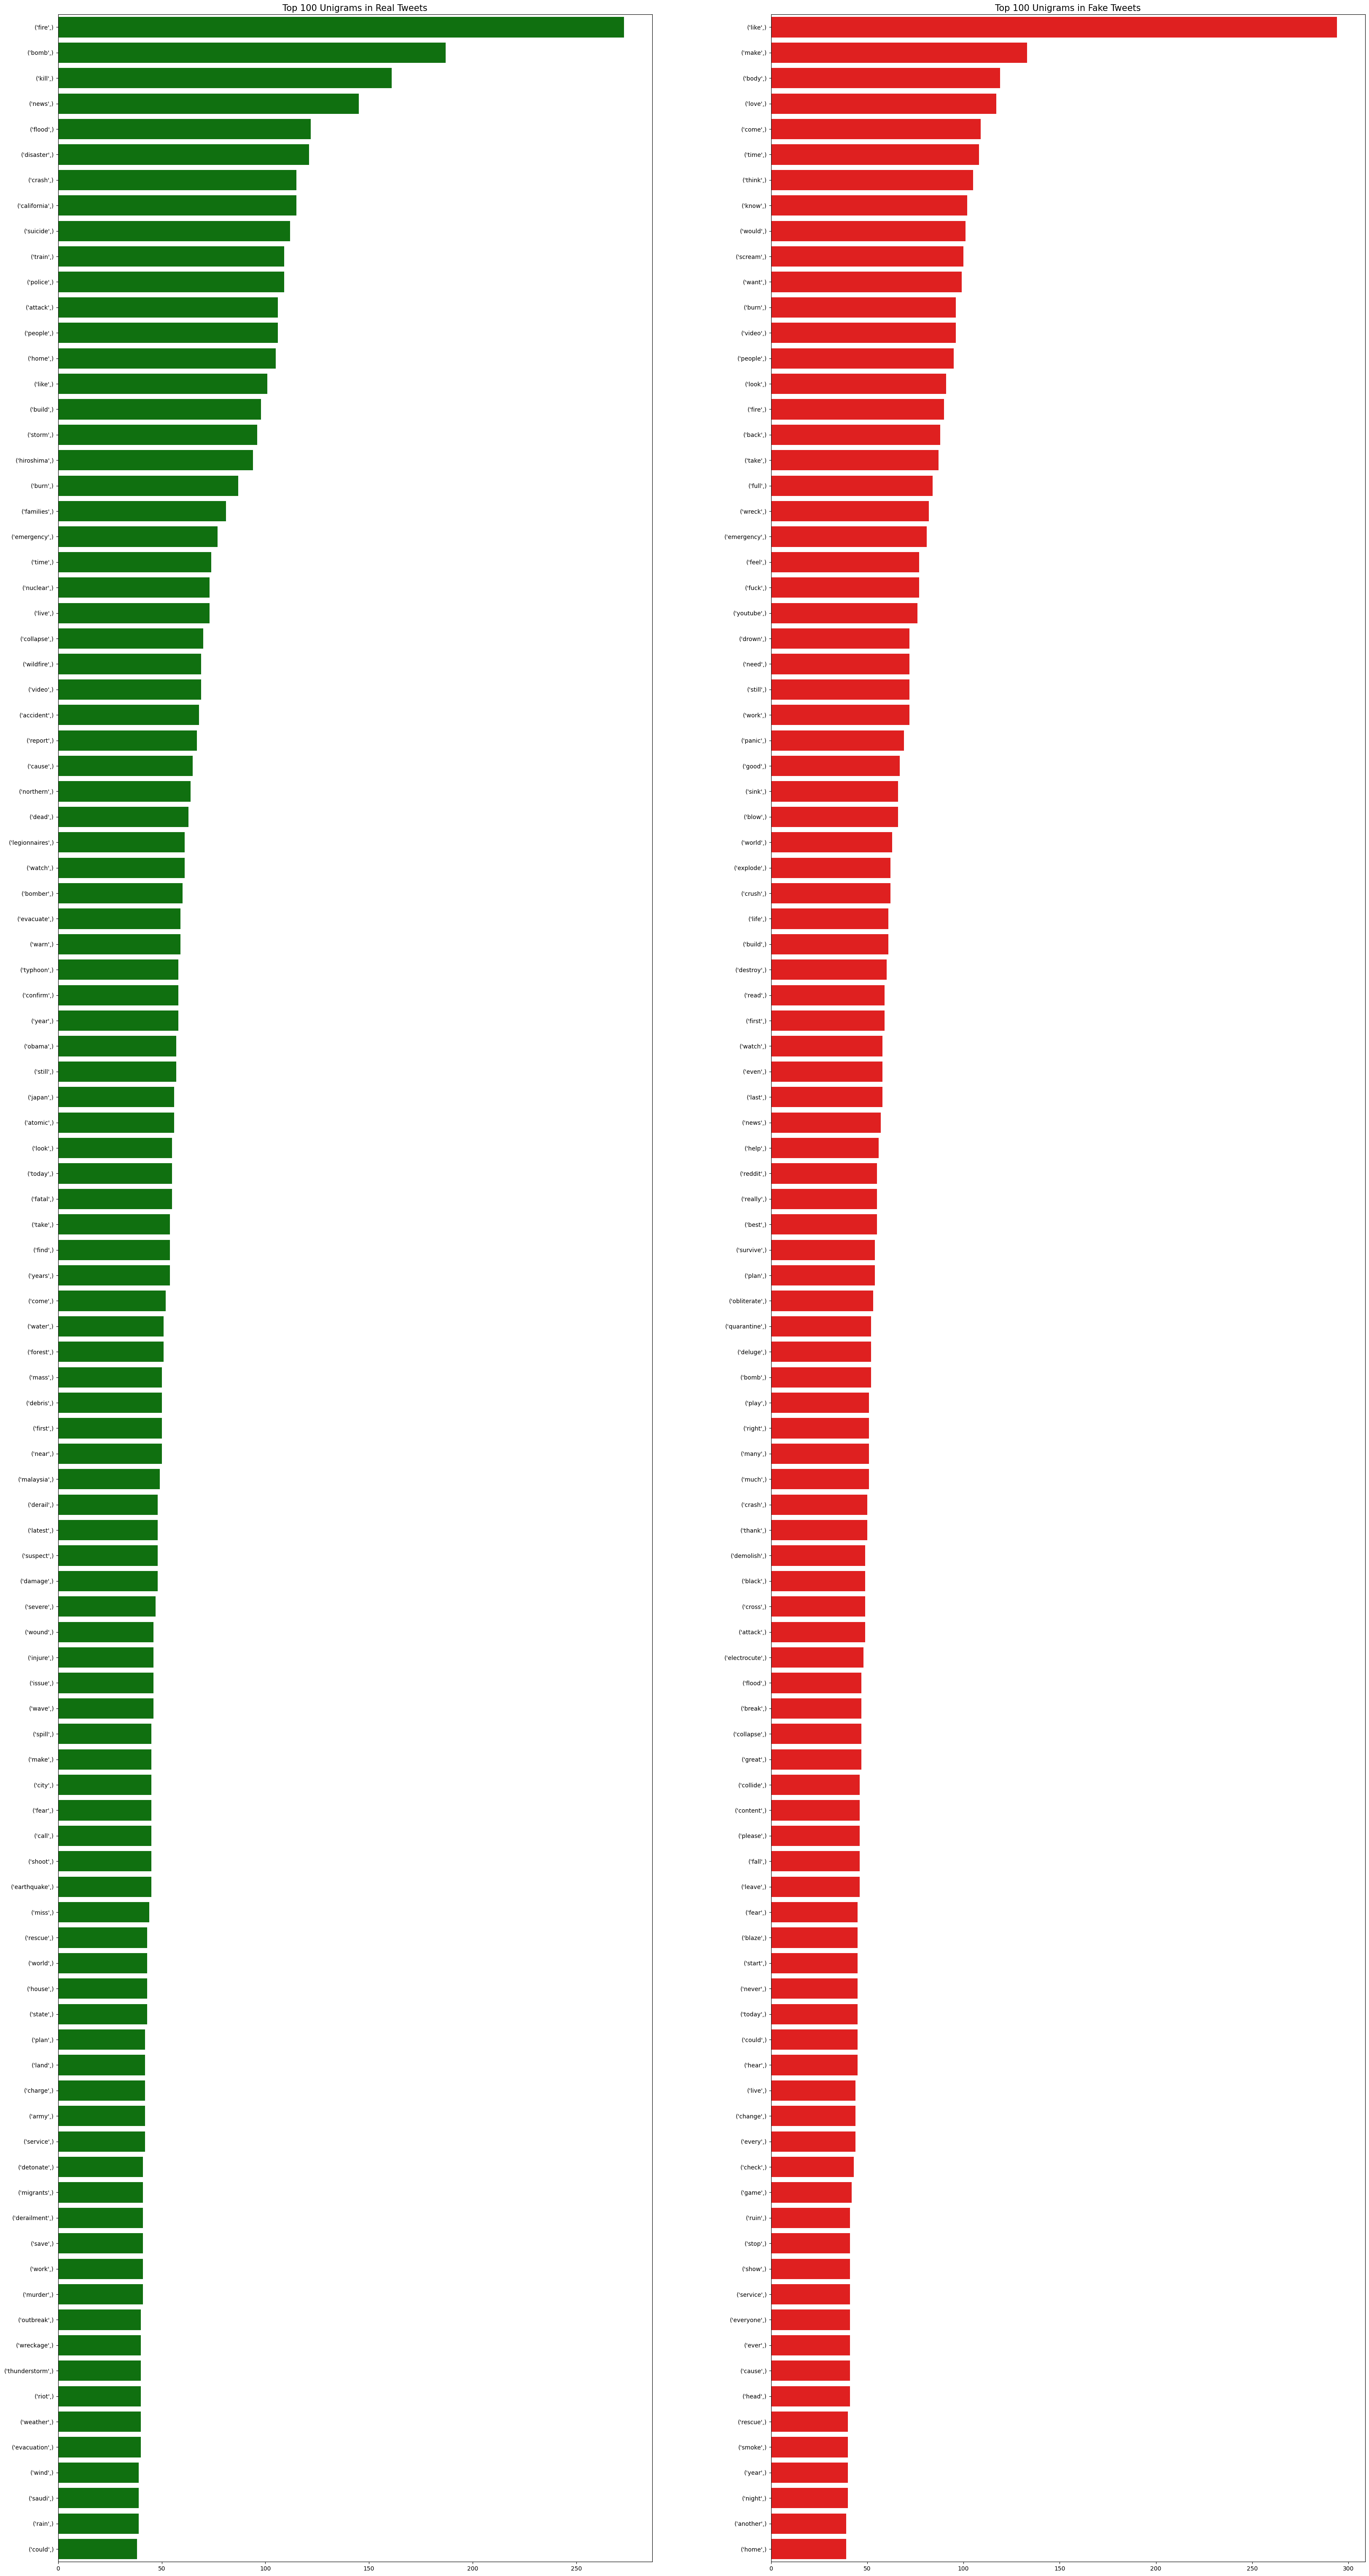

In [46]:
# lets visualize top 100 unigrams
draw_barplots(real_unigrams,fake_unigrams," Unigrams ")

In [47]:
# lets create top 100 bigrams
real_bigrams = get_ngrams(real,2)
fake_bigrams = get_ngrams(fake,2)

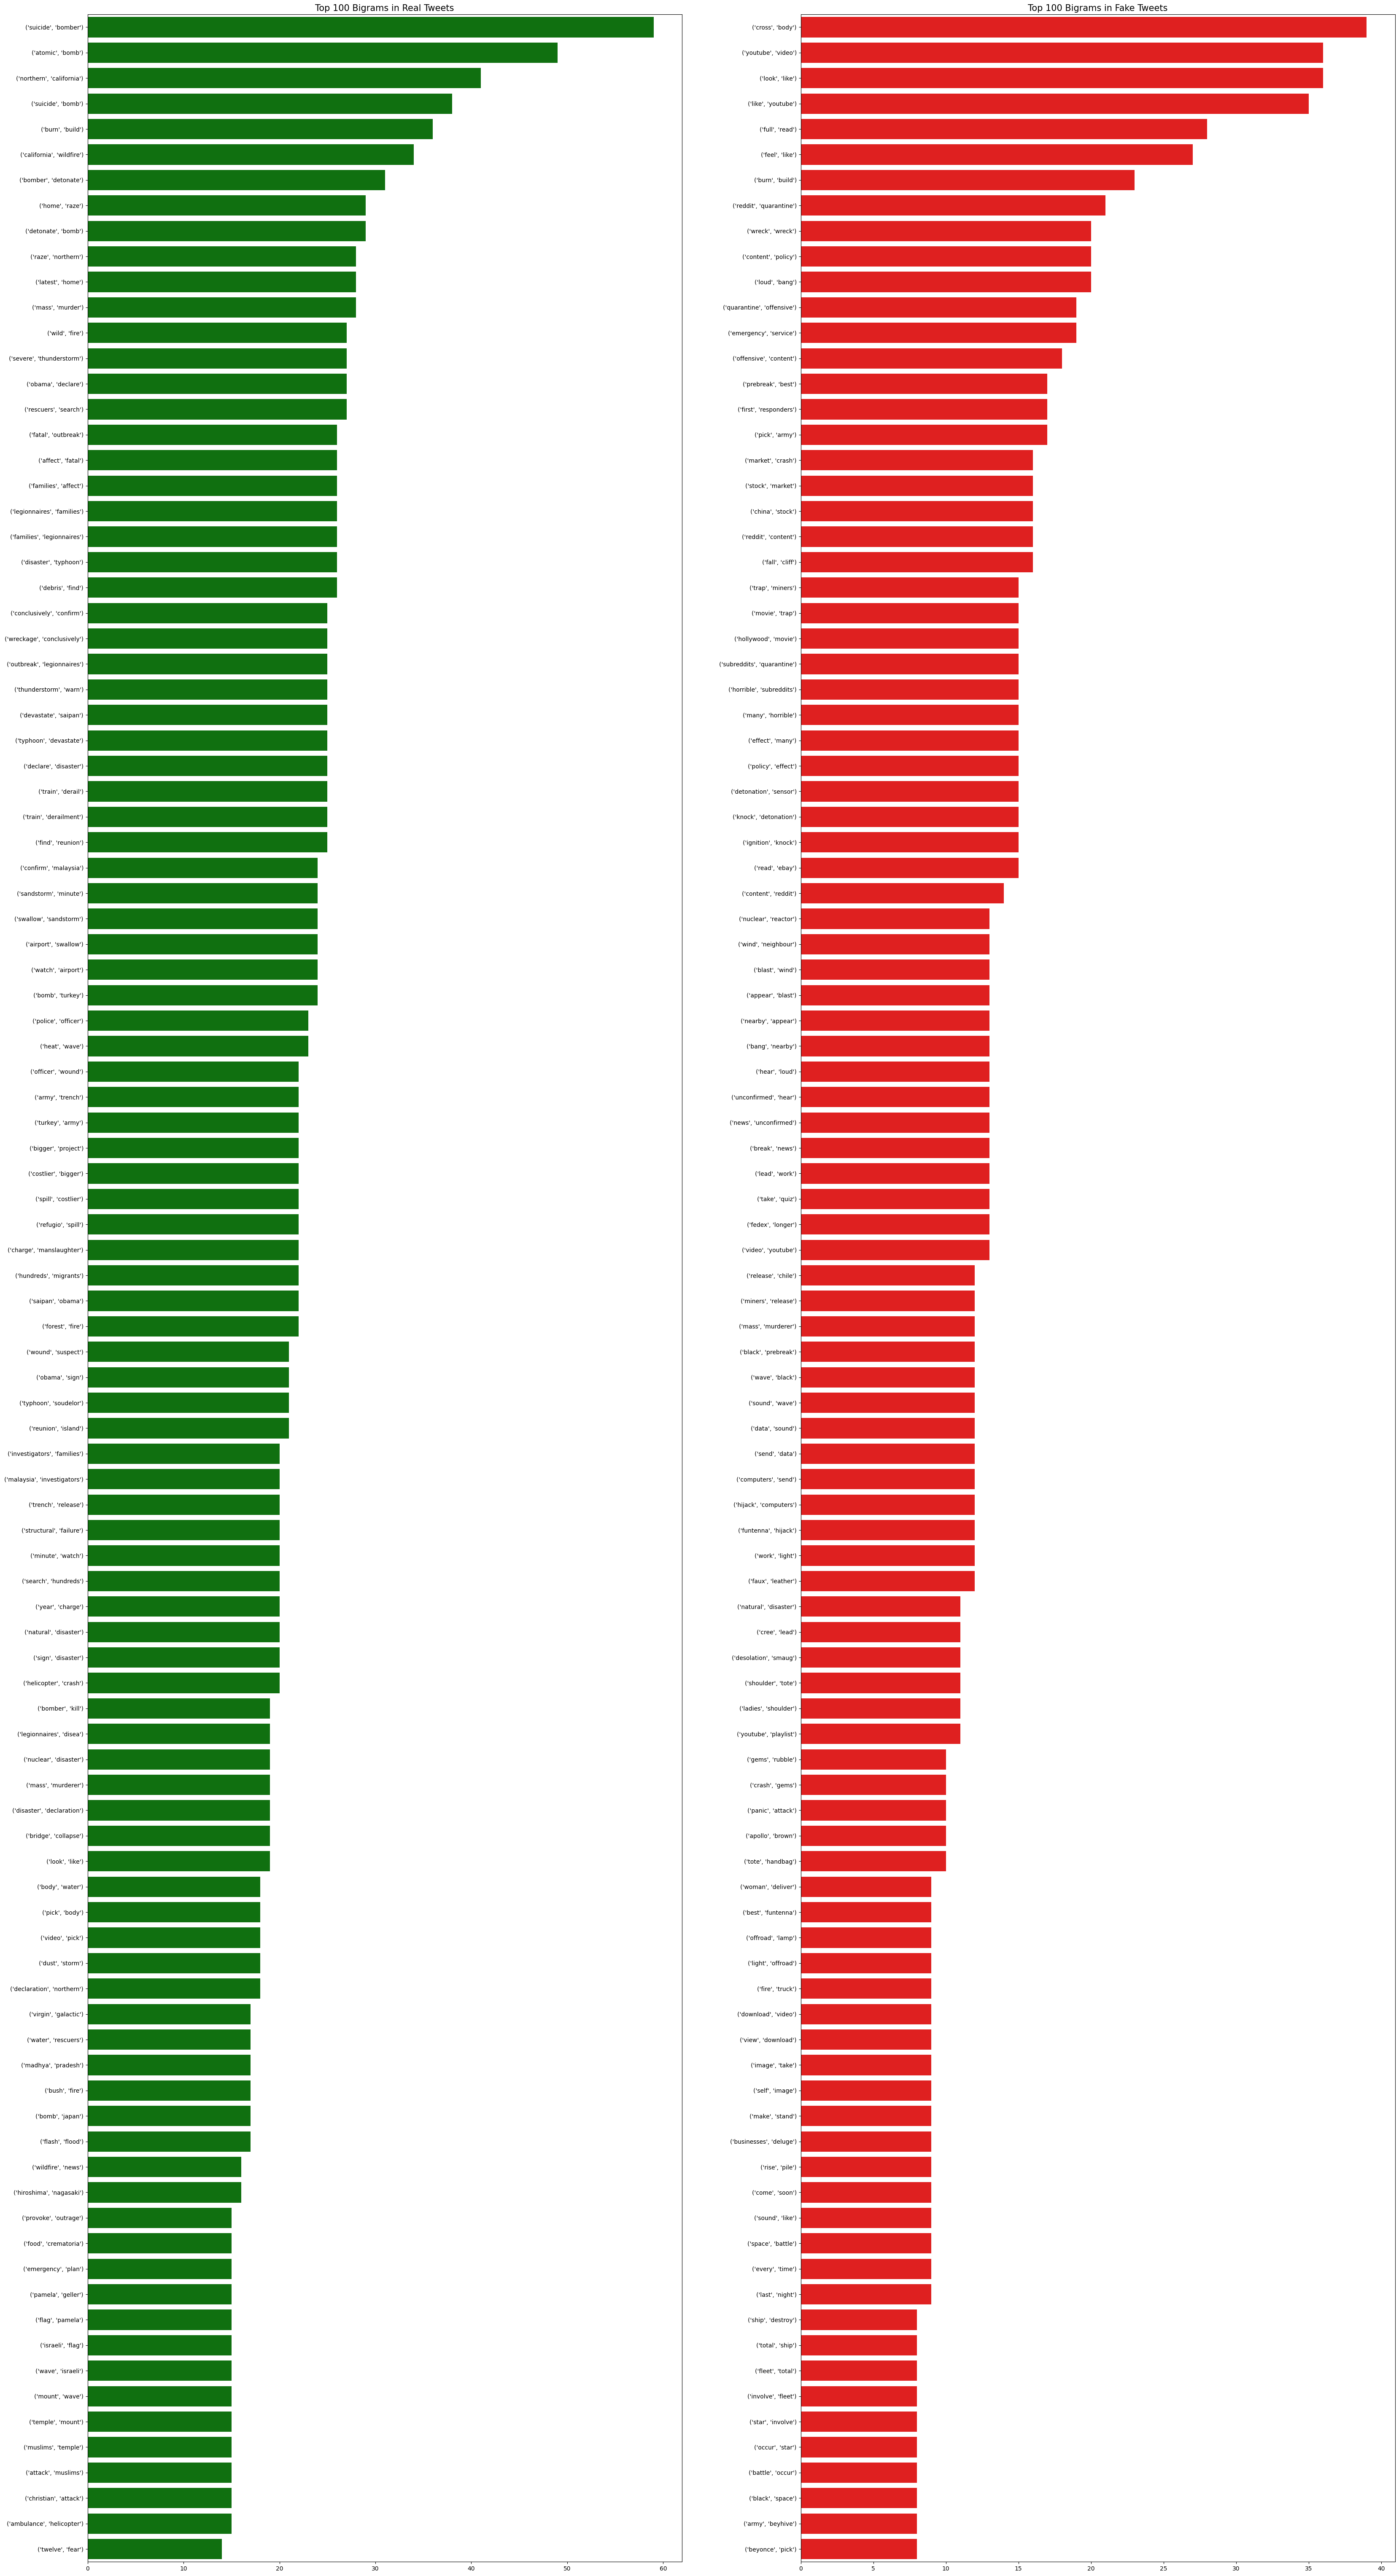

In [48]:
draw_barplots(real_bigrams,fake_bigrams," Bigrams ")

In [49]:
# lets create top 100 trigrams
real_trigrams = get_ngrams(real,3)
fake_trigrams = get_ngrams(fake,3)

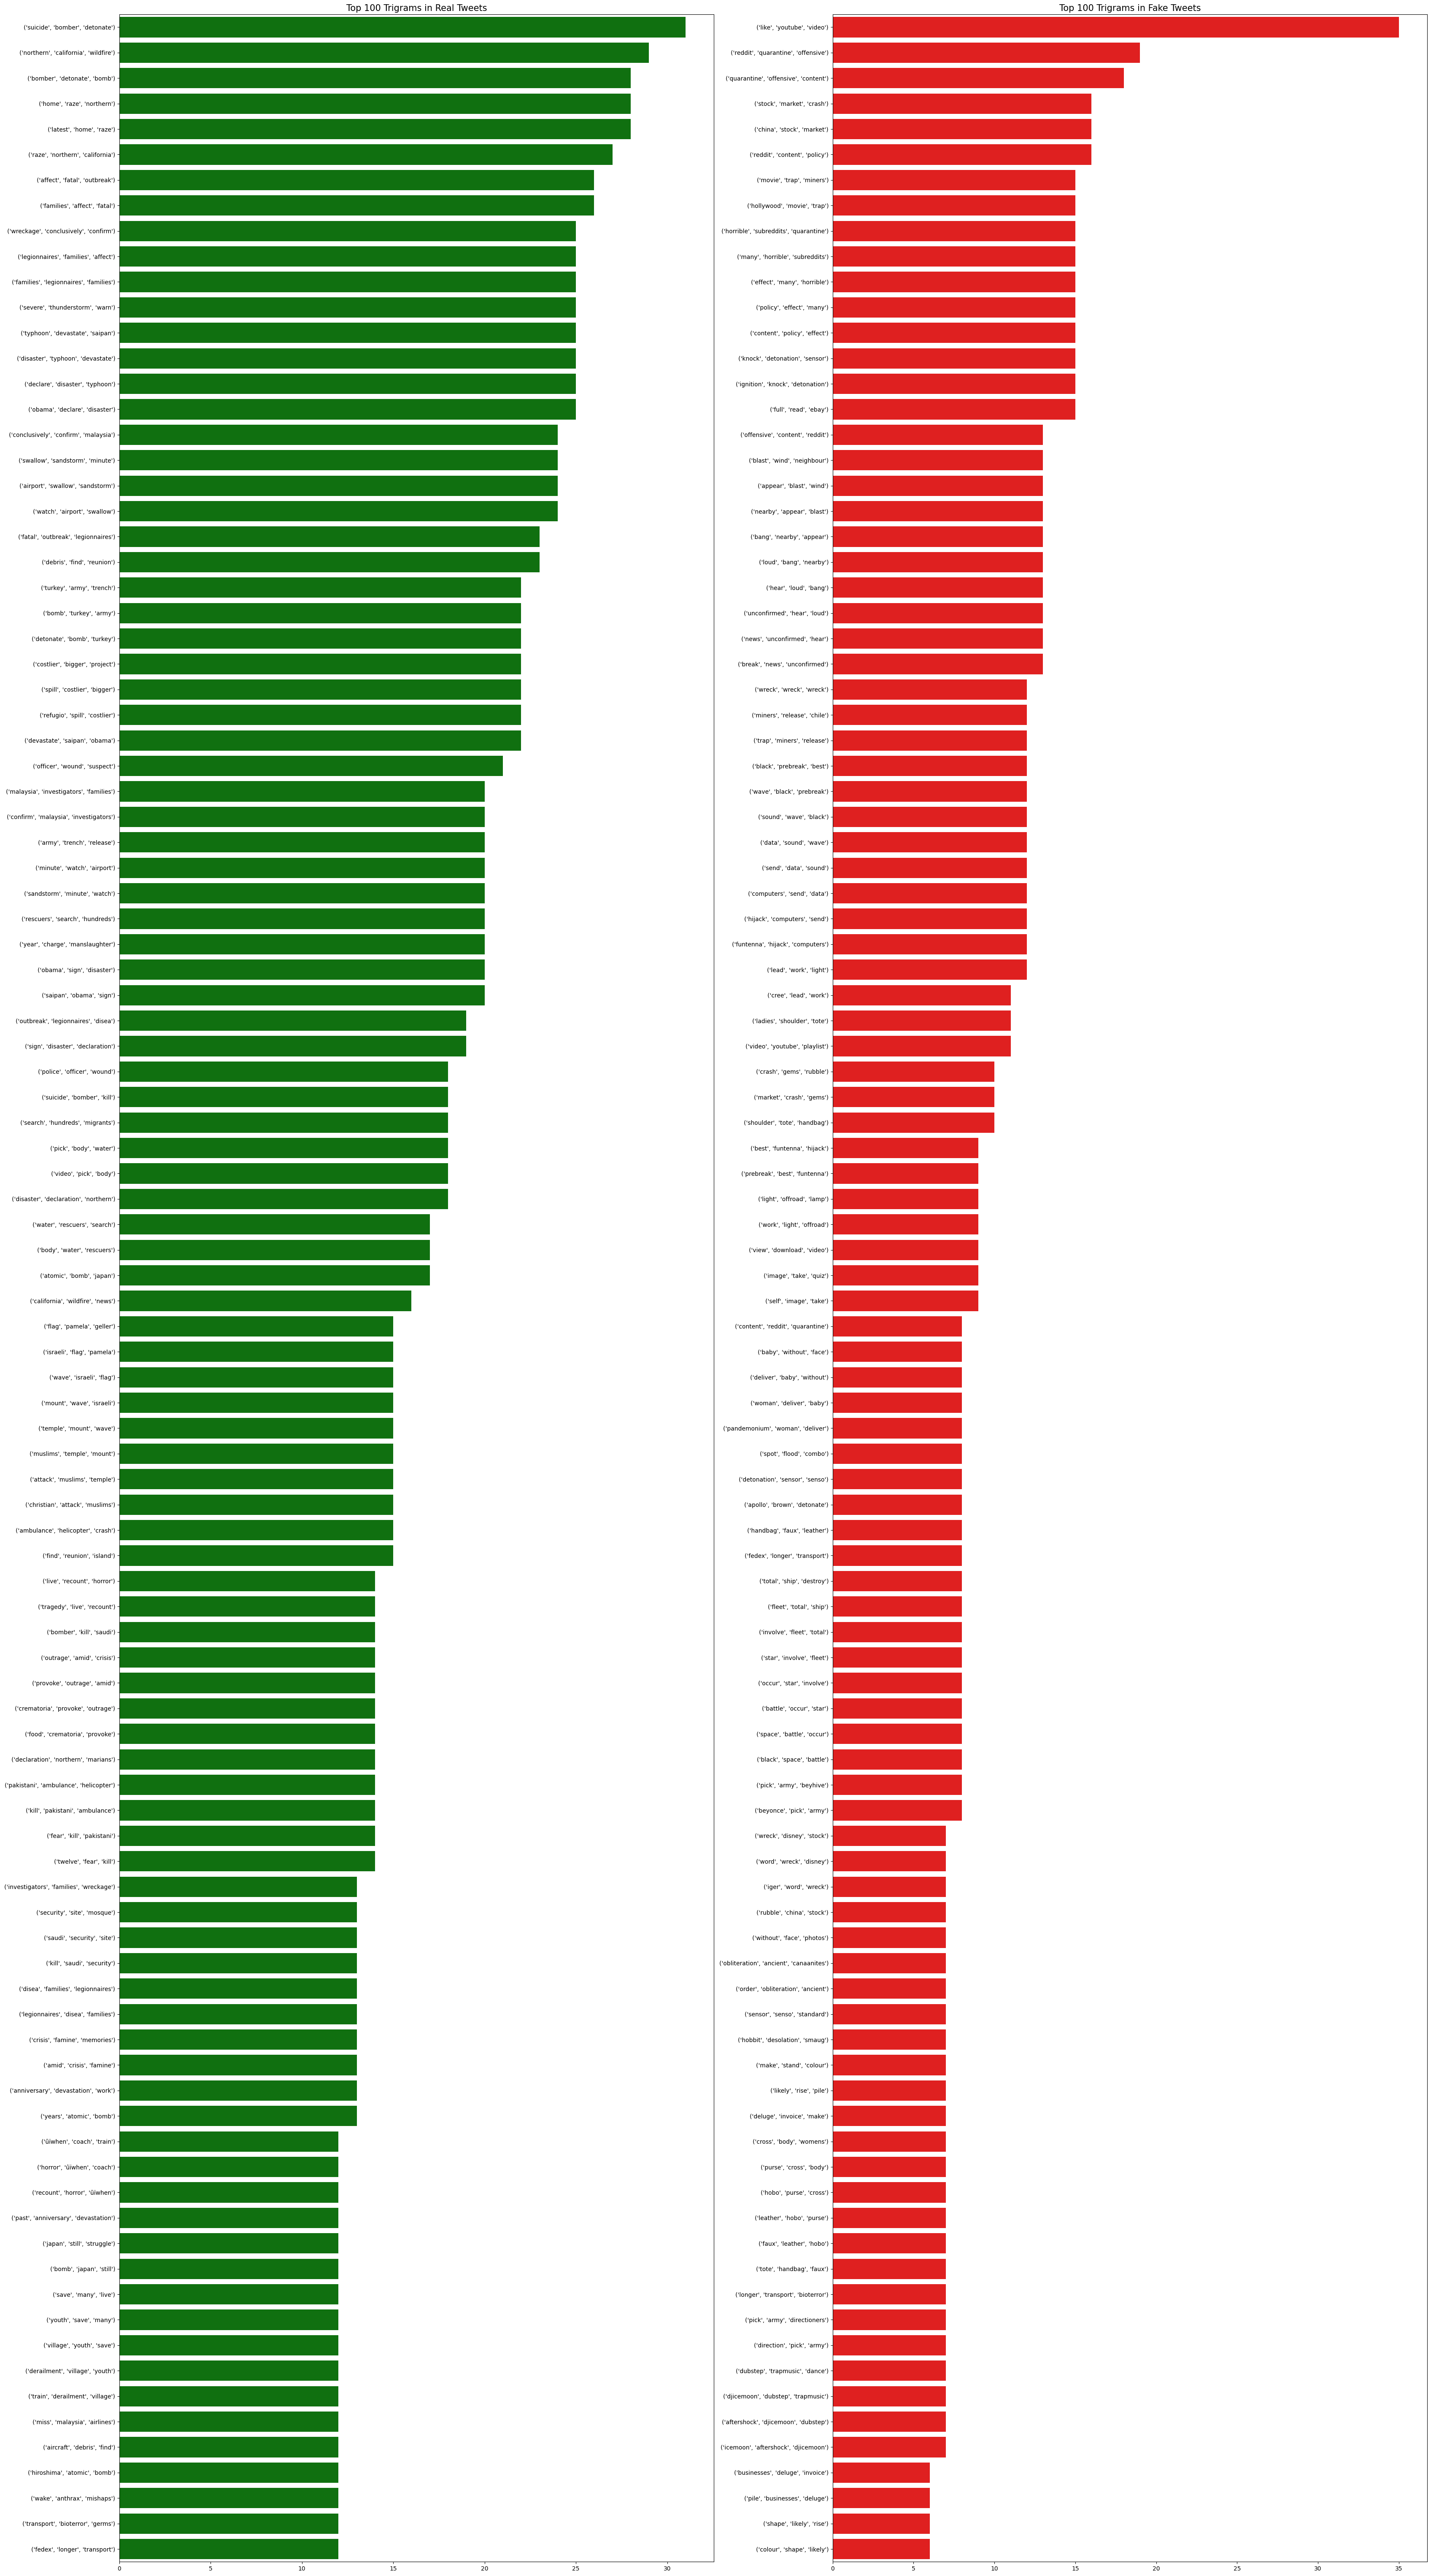

In [50]:
# lets visualize top 100 trigrams
draw_barplots(real_trigrams,fake_trigrams," Trigrams ")


In [51]:
def word_cloud(df):
    comment_words = '' 
    stopwords = set(STOPWORDS) 

    # iterate through the csv file 
    for val in df.text: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 
        
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "
        #return comment_words

    wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(comment_words) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

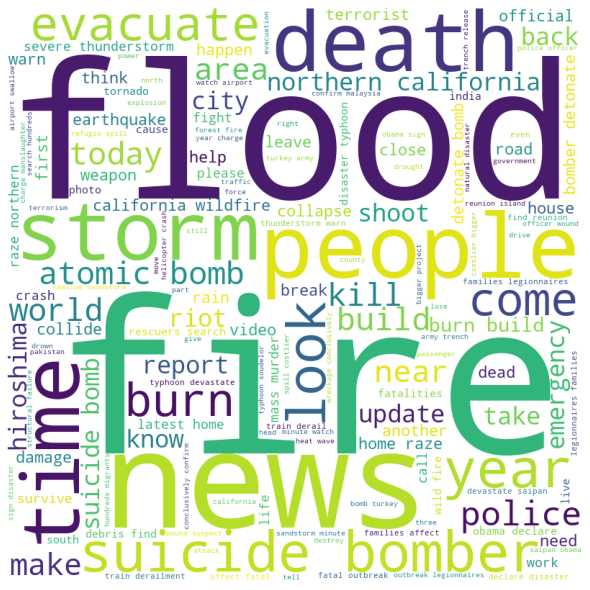

In [52]:
# world cloud for real disaster tweets
word_cloud(real)

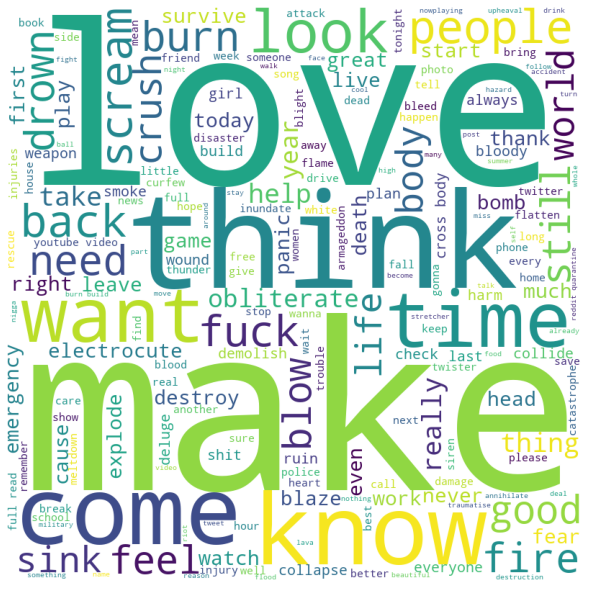

In [53]:
# world cloud for fake disaster tweets
word_cloud(fake)

In [54]:
# function to calculate f1 score for each epoch
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [55]:
# Bag of Words model
from keras.preprocessing.text import Tokenizer

# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [56]:
# lets use only tweet text to build the model
X = train.text
y = train.target

test_id = test.id
test.drop(["id","location","keyword"],1,inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [57]:
# Test train split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [58]:
# create and apply tokenizer on the training dataset
tokenizer = create_tokenizer(X_train)
X_train_set = tokenizer.texts_to_matrix(X_train, mode = 'freq')

In [59]:
# define the model
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dense(128, input_shape=(n_words,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = [get_f1])
    # summarize defined model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [60]:
# create the model
n_words = X_train_set.shape[1]
model = define_model(n_words)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               706560    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 706,689
Trainable params: 706,689
Non-trainable params: 0
_________________________________________________________________


In [61]:
#fit network
model.fit(X_train_set,y_train,epochs=10,verbose=2)

Epoch 1/10
191/191 - 2s - loss: 0.6316 - get_f1: 0.3010 - 2s/epoch - 12ms/step
Epoch 2/10
191/191 - 1s - loss: 0.4471 - get_f1: 0.7696 - 1s/epoch - 6ms/step
Epoch 3/10
191/191 - 1s - loss: 0.3475 - get_f1: 0.8263 - 1s/epoch - 6ms/step
Epoch 4/10
191/191 - 1s - loss: 0.2905 - get_f1: 0.8549 - 1s/epoch - 6ms/step
Epoch 5/10
191/191 - 1s - loss: 0.2504 - get_f1: 0.8815 - 1s/epoch - 6ms/step
Epoch 6/10
191/191 - 1s - loss: 0.2187 - get_f1: 0.8949 - 1s/epoch - 6ms/step
Epoch 7/10
191/191 - 1s - loss: 0.1931 - get_f1: 0.9144 - 1s/epoch - 6ms/step
Epoch 8/10
191/191 - 1s - loss: 0.1723 - get_f1: 0.9225 - 1s/epoch - 6ms/step
Epoch 9/10
191/191 - 1s - loss: 0.1557 - get_f1: 0.9307 - 1s/epoch - 6ms/step
Epoch 10/10
191/191 - 1s - loss: 0.1410 - get_f1: 0.9366 - 1s/epoch - 6ms/step
